<a href="https://colab.research.google.com/github/krushnapavan9/GCN-FMA/blob/main/Graph_convolution_network_FMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref : https://towardsdatascience.com/graph-convolutional-networks-on-node-classification-2b6bbec1d042 \\
Ref: https://github.com/haczqyf/ggc/blob/master/ggc/demo.ipynb

In [ ]:
!wget https://github.com/haczqyf/ggc/raw/master/ggc/data/fma.content

--2020-11-25 18:52:33--  https://github.com/haczqyf/ggc/raw/master/ggc/data/fma.content
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/haczqyf/ggc/master/ggc/data/fma.content [following]
--2020-11-25 18:52:34--  https://raw.githubusercontent.com/haczqyf/ggc/master/ggc/data/fma.content
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5533030 (5.3M) [text/plain]
Saving to: ‘fma.content.1’

fma.content.1       100%[===================>]   5.28M  19.4MB/s    in 0.3s    

2020-11-25 18:52:34 (19.4 MB/s) - ‘fma.content.1’ saved [5533030/5533030]



In [ ]:
!pip install spektral

In [ ]:
#importing dependencies

import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
import scipy.sparse as sp
import numpy as np
from sklearn import preprocessing
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# def encode_onehot(labels):
#     classes = sorted(list(set(labels)))
#     classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
#     labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)

#     return labels_onehot,len(classes)

def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

def load_data(dataset):
    """Load feature matrix and ground truth assignment matrix."""
    print('Loading {} dataset...'.format(dataset))
    
    idx_feature_labels = np.genfromtxt("{}.content".format(dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_feature_labels[:, 1:-1], dtype=np.float32)
    labels = idx_feature_labels[:, -1]

    idx = np.array(idx_feature_labels[:, 0], dtype=np.int32)
    nodelist_mapping = dict(enumerate(idx))

    # print('Samples={},Features={},Labels={}'.format(features.shape[0],features.shape[1],labels.shape[1]))

    return features.toarray(), labels, nodelist_mapping

def preprocess_features(features):
    """Row-normalize feature matrix"""
    features = preprocessing.normalize(features, norm='l1', axis=1)
    return features

def show_info(adj):
    """Show basic information about a graph using its adjacency matrix"""
    N = adj.shape[0]
    count_edges = int(np.sum(np.count_nonzero(adj)) / 2)
    print("Nodes={},Edges={},Density={:.5f}".format(adj.shape[0],count_edges,count_edges/ (N * (N-1) / 2)))

In [ ]:
X, labels, nodelist_mapping = load_data(dataset='fma')
X = preprocess_features(X)
labels_encoded, classes = encode_label(labels)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
num_classes = len(set(labels))

Loading fma dataset...


In [ ]:
import itertools
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse.csgraph import minimum_spanning_tree

In [ ]:
def mst_graph(X):
    """Returns Minimum Spanning Tree (MST) graph from the feature matrix.
    Parameters
    ----------
    X : ndarray, shape (N, F)
        N samples and F-dimensional features.
    Returns
    -------
    adj : ndarray, shape (N, N)
        The adjacency matrix of the constructed mst graph.
    """
    D = euclidean_distances(X, X)
    adj_directed = minimum_spanning_tree(D).toarray()
    adj = adj_directed + adj_directed.T
    adj[adj > 0] = 1
    np.fill_diagonal(adj,0)

    return adj

def cknn_graph(X, delta, k):
    """Returns Continuous k-Nearest Neighbor (CkNN) graph from the feature matrix.
    Parameters
    ----------
    X : ndarray, shape (N, F)
        N samples and F-dimensional features.
    delta : float, delta > 0
        Parameter for cknn.
    k : int, k >= 1
        Parameter for cknn: the k-th nearest neighbour.
    Returns
    -------
    adj : ndarray, shape (N, N)
        The adjacency matrix of the constructed cknn graph.
    
    References
    ----------
    .. [1] Tyrus Berry, Timothy Sauer. Consistent manifold representation for topological data analysis.
           Foundations of Data Science, 2019, 1 (1) : 1-38. doi: 10.3934/fods.2019001
    """
    assert k < X.shape[0]

    D = euclidean_distances(X, X)
    N = D.shape[0]
    np.fill_diagonal(D,0)
    D_k = np.sort(D)

    adj = np.zeros([N, N])
    adj[np.square(D) < delta * delta * np.dot(D_k[:,k].reshape(-1,1),D_k[:,k].reshape(1,-1))] = 1
    np.fill_diagonal(adj,0)

    return adj


In [ ]:
%%time
A = cknn_graph(X=X, delta=1, k=199)

CPU times: user 398 ms, sys: 183 ms, total: 581 ms
Wall time: 379 ms


In [ ]:
A = A + mst_graph(X=X)
A[A > 0] = 1

In [ ]:
show_info(A)

Nodes=2000,Edges=176463,Density=0.08828


In [ ]:
print(A[:5,:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# unused

In [ ]:
# # Layout: spring. Node color: ground truth class label.
# fig, ax = plt.subplots(1, 1, figsize=(8,8))
# nx.draw_networkx(G,pos=nx.spring_layout(G, seed=123),
#                  node_color=node_colors,
#                  node_size=2,
#                  with_labels=False,
#                  edge_color="#b9b9b9",
#                  width=0.2,
#                  ax=ax)

# frame1 = plt.gca()
# frame1.axes.get_xaxis().set_visible(False)
# frame1.axes.get_yaxis().set_visible(False)
# plt.show()

In [ ]:
# all_data = []
# all_edges = []

# for root,dirs,files in os.walk('./cora'):
#     for file in files:
#         if '.content' in file:
#             with open(os.path.join(root,file),'r') as f:
#                 all_data.extend(f.read().splitlines())
#         elif 'cites' in file:
#             with open(os.path.join(root,file),'r') as f:
#                 all_edges.extend(f.read().splitlines())

                
# #Shuffle the data because the raw data is ordered based on the label
# random_state = 77
# all_data = shuffle(all_data,random_state=random_state)

In [ ]:
# labels = []
# nodes = []
# X = []

# for i,data in enumerate(all_data):
#     elements = data.split('\t')
#     labels.append(elements[-1])
#     X.append(elements[1:-1])
#     nodes.append(elements[0])

# X = np.array(X,dtype=int)
# N = X.shape[0] #the number of nodes
# F = X.shape[1] #the size of node features
# print('X shape: ', X.shape)


# #parse the edge
# edge_list=[]
# for edge in all_edges:
#     e = edge.split('\t')
#     edge_list.append((e[0],e[1]))

# print('\nNumber of nodes (N): ', N)
# print('\nNumber of features (F) of each node: ', F)
# print('\nCategories: ', set(labels))

# num_classes = len(set(labels))
# print('\nNumber of classes: ', num_classes)

# continue

In [ ]:
def limit_data(labels,limit=0.5,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    limit = len(labels)*limit/len(set(labels))

    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

train_idx,val_idx,test_idx = limit_data(labels)

train_idx,val_idx,test_idx = range(96), range(96,300),range(300,2000)

#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [ ]:
# G = nx.Graph(A)
# df = pd.DataFrame()
# df["class"] = list(np.nonzero(Y)[1] + 1)

# colors = sns.color_palette("Set1", n_colors=len(set(df["class"])), desat=1.0)
# node_colors = []
# for node in G.nodes():
#     node_colors.append(colors[int(df.loc[node]["class"])-1])

In [ ]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'0': 250, '1': 250, '2': 250, '3': 250, '4': 250, '5': 250, '6': 250, '7': 250})


In [ ]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'0': 12, '1': 12, '2': 12, '3': 12, '4': 12, '5': 12, '6': 12, '7': 12})


In [ ]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'4': 32, '5': 30, '1': 28, '2': 27, '3': 23, '7': 22, '0': 21, '6': 21})


In [ ]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in test_idx])))

Validation Data Distribution: 
Counter({'6': 217, '0': 217, '7': 216, '3': 215, '2': 211, '1': 210, '5': 208, '4': 206})


In [ ]:
G = nx.Graph(A)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2000
Number of edges: 176463
Average degree: 176.4630


code for training : https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py

In [ ]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 2000           # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GraphConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN] 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 140)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 16)           2240        dropout[0][0]                    
                                                                 input_2[0][0]         

In [ ]:
#Train model
%%time
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])


Epoch 1/2000
1/1 [==============================] - 0s 178ms/step - loss: 0.0887 - acc: 0.2917 - val_loss: 0.1971 - val_acc: 0.3235
Epoch 2/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0883 - acc: 0.2917 - val_loss: 0.1972 - val_acc: 0.3235
Epoch 3/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.0884 - acc: 0.3021 - val_loss: 0.1973 - val_acc: 0.3186
Epoch 4/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0882 - acc: 0.3021 - val_loss: 0.1974 - val_acc: 0.3186
Epoch 5/2000
1/1 [==============================] - 0s 37ms/step - loss: 0.0884 - acc: 0.2917 - val_loss: 0.1973 - val_acc: 0.3186
Epoch 6/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0884 - acc: 0.2917 - val_loss: 0.1973 - val_acc: 0.3284
Epoch 7/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0886 - acc: 0.2917 - val_loss: 0.1972 - val_acc: 0.3284
Epoch 8/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0886 - 

In [ ]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.13      0.14      0.14       210
           2       0.26      0.33      0.29       211
           3       0.34      0.68      0.46       215
           4       0.33      0.59      0.42       206
           5       0.28      0.22      0.24       208
           6       0.00      0.00      0.00       217
           7       0.36      0.42      0.39       216

    accuracy                           0.30      1700
   macro avg       0.21      0.30      0.24      1700
weighted avg       0.21      0.30      0.24      1700



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


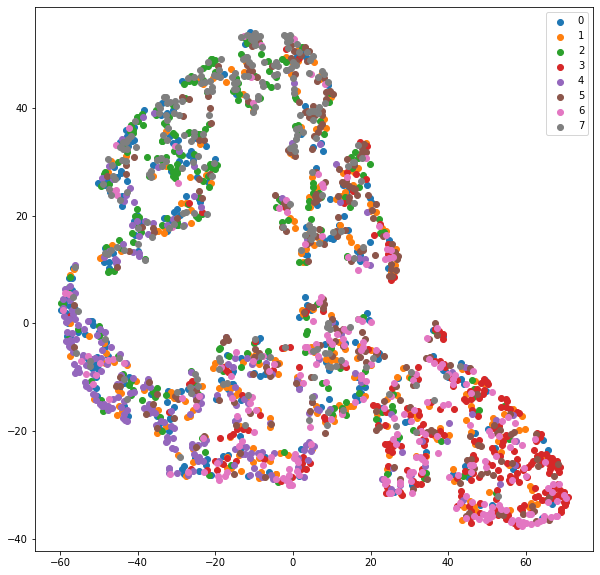

In [ ]:
#Get the hidden layer representation after the first GCN layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)